# LLM Training with TTML
Fine-tuning LLMs on GSM8K dataset using TT-Metal

In [1]:
%env TT_METAL_HOME=/home/ubuntu/tt-metal
%env TT_METAL_RUNTIME_ROOT=/home/ubuntu/tt-metal

env: TT_METAL_HOME=/home/ubuntu/tt-metal
env: TT_METAL_RUNTIME_ROOT=/home/ubuntu/tt-metal


## Hyperparameters

In [2]:
BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 16
MAX_STEPS = 1000
EVAL_EVERY = 50
MAX_LR = 3e-4
WARMUP_STEPS = 200

# Sampling
NUM_GENERATIONS = 4 # K in TopK
NUM_ACC_SAMPLES = 10
SAMPLE_TEMPERATURE = 0.2


NUM_LOSS_BATCHES = 50

USE_MOREH_ADAMW = True

## Model Selection

In [3]:
# model_id = "meta-llama/Llama-3.2-1B-Instruct"
# CONFIG = "training_shakespeare_llama3_2_1B_fixed.yaml"

model_id = "Qwen/Qwen3-0.6B"
CONFIG = "training_shakespeare_qwen3_0_6B.yaml"

# model_id = "Qwen/Qwen3-1.7B"
# CONFIG = "training_shakespeare_qwen3_1_7B.yaml"

# model_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
# CONFIG = "training_shakespeare_tinyllama.yaml"

# model_id = "Qwen/Qwen3-4B"
# CONFIG = "training_shakespeare_qwen3_4B.yaml"

## Imports

In [4]:
import os
import re
import math
import gc
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import datasets
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import hf_hub_download
from tqdm.auto import tqdm
from typing import Optional
from time import time
from matplotlib import pyplot as plt

import ttml
from ttml.common.config import DeviceConfig, get_training_config, load_config
from ttml.common.model_factory import TransformerModelFactory
from ttml.common.utils import round_up_to_tile, create_optimizer, initialize_device

os.environ["TOKENIZERS_PARALLELISM"] = "true"
torch.manual_seed(42)
TILE_SIZE = 32

2026-01-17 23:20:10.996 | DEBUG    | ttnn:<module>:77 - Initial ttnn.CONFIG:
Config{cache_path=/home/ubuntu/.cache/ttnn,model_cache_path=/home/ubuntu/.cache/ttnn/models,tmp_dir=/tmp/ttnn,enable_model_cache=false,enable_fast_runtime_mode=true,throw_exception_on_fallback=false,enable_logging=false,enable_graph_report=false,enable_detailed_buffer_report=false,enable_detailed_tensor_report=false,enable_comparison_mode=false,comparison_mode_should_raise_exception=false,comparison_mode_pcc=0.9999,root_report_path=generated/ttnn/reports,report_name=std::nullopt,std::nullopt}


## Helper Functions

In [5]:
def round_up(value: int) -> int:
    return ((value + TILE_SIZE - 1) // TILE_SIZE) * TILE_SIZE

def build_causal_mask(T: int):
    m = np.tril(np.ones((T, T), dtype=np.float32))
    return m.reshape(1, 1, T, T)

class KvCacheRegistry:
    def __init__(self):
        self._caches = {}
        self._config = None
    
    def set_config(self, transformer_config, max_sequence_length):
        self._config = {
            'num_blocks': transformer_config.num_blocks,
            'num_groups': transformer_config.num_groups,
            'max_sequence_length': max_sequence_length,
            'head_dim': getattr(transformer_config, 'head_dim', None) or (transformer_config.embedding_dim // transformer_config.num_heads)
        }
    
    def get(self, batch_size: int):
        if batch_size not in self._caches:
            self._caches[batch_size] = ttml.models.KvCache(
                self._config['num_blocks'], batch_size, self._config['num_groups'],
                self._config['max_sequence_length'], self._config['head_dim']
            )
        return self._caches[batch_size]

kv_cache_registry = KvCacheRegistry()

def create_causal_mask_kv(query_len: int, prompt_len: int = 0) -> ttml.autograd.Tensor:
    whole_len = prompt_len + query_len
    padded_q = round_up(query_len)
    padded_w = round_up(whole_len)
    mask = np.zeros((padded_q, padded_w), dtype=np.float32)
    for i in range(query_len):
        for j in range(prompt_len + i + 1):
            mask[i, j] = 1.0
    return ttml.autograd.Tensor.from_numpy(mask.reshape(1, 1, padded_q, padded_w), ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16)

def tokens_to_tensor_kv_batch(tokens_batch: list, seq_len: int) -> ttml.autograd.Tensor:
    batch_size = len(tokens_batch)
    padded_len = round_up(seq_len)
    padded = np.zeros((batch_size, padded_len), dtype=np.uint32)
    for b in range(batch_size):
        padded[b, :len(tokens_batch[b])] = tokens_batch[b]
    return ttml.autograd.Tensor.from_numpy(padded.reshape(batch_size, 1, 1, padded_len), ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.UINT32)

def build_logits_mask(vocab_size: int, padded_vocab_size: int) -> ttml.autograd.Tensor:
    logits_mask = np.zeros((1, 1, 1, padded_vocab_size), dtype=np.float32)
    logits_mask[:, :, :, vocab_size:] = 1e6
    return ttml.autograd.Tensor.from_numpy(logits_mask, ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16)

def get_loss_over_devices(loss):
    device = ttml.autograd.AutoContext.get_instance().get_device()
    composer = ttml.core.distributed.concat_mesh_to_tensor_composer(device, 0)
    loss_numpy = loss.to_numpy(composer=composer)
    return loss_numpy.mean()

def cosine_schedule_with_warmup(step, total_steps, warmup_steps, max_lr, min_lr=0.0):
    if step < warmup_steps:
        return max_lr * (step / warmup_steps)
    progress = (step - warmup_steps) / (total_steps - warmup_steps)
    return min_lr + (max_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

In [6]:
def extract_answer(text: str) -> Optional[str]:
    match = re.search(r'####\s*(-?[\d,\.]+)', text)
    if match:
        return match.group(1).replace(',', '')
    numbers = re.findall(r'-?[\d,\.]+', text)
    return numbers[-1].replace(',', '') if numbers else None

def normalize_answer(ans: str) -> Optional[float]:
    if ans is None:
        return None
    try:
        return float(ans)
    except ValueError:
        return None

def answers_match(a, b):
    return a is not None and b is not None and abs(a - b) < 1e-6

## Dataset Classes

In [7]:
class TokenizedDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def tokenize_dataset(data, tokenizer):
    X = [sample["question"] for sample in data]
    y = [sample["answer"] for sample in data]
    X = tokenizer(X, return_tensors="np", add_special_tokens=False)["input_ids"]
    y = tokenizer(y, return_tensors="np", add_special_tokens=False)["input_ids"]
    return X, y

In [8]:
class CollateFn:
    def __init__(self, eos_token_id, max_sequence_length, padded_vocab_size):
        self.eos_token_id = eos_token_id
        self.max_sequence_length = max_sequence_length
        self.padded_vocab_size = padded_vocab_size

    def __call__(self, batch):
        X = [sample[0] for sample in batch]
        Y = [sample[1] for sample in batch]
        batch_size = len(X)

        data_np = np.full((batch_size, self.max_sequence_length), self.eos_token_id, dtype=np.uint32)
        mask_lens = []

        for i in range(batch_size):
            x_tokens = X[i]
            y_tokens = Y[i]
            combined_length = len(x_tokens) + len(y_tokens)

            if combined_length > self.max_sequence_length:
                available_space = self.max_sequence_length - len(y_tokens)
                if available_space > 0:
                    x_tokens = x_tokens[:available_space]
                    data_np[i, :len(x_tokens)] = x_tokens
                    data_np[i, len(x_tokens):len(x_tokens) + len(y_tokens)] = y_tokens
                else:
                    data_np[i, :self.max_sequence_length] = y_tokens[:self.max_sequence_length]
                    x_tokens = []
            else:
                data_np[i, :len(x_tokens)] = x_tokens
                data_np[i, len(x_tokens):len(x_tokens) + len(y_tokens)] = y_tokens

            mask_lens.append(len(x_tokens))

        X_np = np.expand_dims(data_np, axis=(1, 2))
        y_np = np.full((batch_size, self.max_sequence_length), self.eos_token_id, dtype=np.uint32)
        y_np[:, 0:-1] = X_np[:, 0, 0, 1:]

        loss_scaler_np = np.full((batch_size, 1, self.max_sequence_length, 1), 1.0, dtype=np.float32)
        for i, mask_len in enumerate(mask_lens):
            loss_scaler_np[i, :, :mask_len, :] = 0.0
            pad_positions = X_np[i, 0, 0, :] == self.eos_token_id
            loss_scaler_np[i, :, pad_positions, :] = 0.0
        loss_scaler_ratio = self.max_sequence_length * batch_size / np.sum(loss_scaler_np)
        loss_scaler_np = loss_scaler_np * loss_scaler_ratio

        return X_np, y_np, loss_scaler_np

In [9]:
def get_batch_generator(dataloader, device_config=None):
    mapper = None
    if device_config is not None:
        device = ttml.autograd.AutoContext.get_instance().get_device()
        mapper = ttml.core.distributed.shard_tensor_to_mesh_mapper(device, 0)

    while True:
        for batch in dataloader:
            X_np, y_np, loss_scaler_np = batch
            X = ttml.autograd.Tensor.from_numpy(X_np, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.UINT32, mapper)
            y = ttml.autograd.Tensor.from_numpy(y_np, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.UINT32, mapper)
            loss_scaler = ttml.autograd.Tensor.from_numpy(loss_scaler_np, ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16, mapper)
            yield (X, y, loss_scaler)

## Generation

In [10]:
def generate_with_kv_cache(model, tokenizer, prompt_tokens, logits_mask_tensor, max_gen_tokens,
                           max_sequence_length, temperature=0.2, batch_size=1):
    kv_cache = kv_cache_registry.get(batch_size)
    kv_cache.reset()
    prompt_len = len(prompt_tokens)
    generated = [list(prompt_tokens) for _ in range(batch_size)]
    finished = [False] * batch_size

    for step in tqdm(range(min(max_gen_tokens, max_sequence_length - prompt_len)), leave=False):
        if kv_cache.get_cache_position() == 0:
            input_tokens_batch = [g[:] for g in generated]
            seq_len = len(input_tokens_batch[0])
            processed = 0
        else:
            input_tokens_batch = [[g[-1]] for g in generated]
            seq_len = 1
            processed = len(generated[0]) - 1

        token_tensor = tokens_to_tensor_kv_batch(input_tokens_batch, seq_len)
        mask = create_causal_mask_kv(seq_len, processed)
        logits = model(token_tensor, mask, kv_cache=kv_cache, new_tokens=seq_len)

        logits_np = logits.to_numpy()
        all_finished = True
        for b in range(batch_size):
            if finished[b]:
                continue
            batch_logits = logits_np[b:b+1, :, :, :]
            batch_logits_tensor = ttml.autograd.Tensor.from_numpy(batch_logits, ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16)
            next_token_tensor = ttml.ops.sample.sample_op(batch_logits_tensor, temperature, np.random.randint(low=1, high=int(1e9)), logits_mask_tensor)
            next_token = int(next_token_tensor.to_numpy().flatten()[seq_len - 1])
            if next_token == tokenizer.eos_token_id:
                finished[b] = True
            else:
                generated[b].append(next_token)
                all_finished = False

        ttml.autograd.AutoContext.get_instance().reset_graph()
        if all_finished:
            break

    return [tokenizer.decode(g[prompt_len:]) for g in generated]

## Validation

In [11]:
def validate(tt_model, tokenizer, val_batch_generator, testing_data, loss_fn, causal_mask,
             logits_mask_tensor, max_sequence_length, max_gen_tokens, current_step, num_samples):
    reduce = ttml.ops.ReduceType.NONE
    ttml.autograd.AutoContext.get_instance().set_gradient_mode(ttml.autograd.GradMode.DISABLED)
    tt_model.eval()

    cur_val_losses = []
    for batch_idx in tqdm(range(NUM_LOSS_BATCHES), desc="Computing val loss"):
        val_X, val_y, val_loss_scaler = next(val_batch_generator)
        val_logits = tt_model(val_X, causal_mask)
        val_loss = loss_fn(val_logits, val_y, reduce)
        val_loss = val_loss * val_loss_scaler
        val_loss = get_loss_over_devices(val_loss)
        cur_val_losses.append(val_loss)
        ttml.autograd.AutoContext.get_instance().reset_graph()
        if batch_idx % 100 == 0:
            gc.collect()

    mean_loss = float(np.mean(cur_val_losses))

    correct_top1 = 0
    correct_topk = 0
    total = 0
    eval_samples = min(NUM_ACC_SAMPLES, len(testing_data))

    start_time = time()

    for idx in tqdm(range(eval_samples), desc="Evaluating accuracy"):
        tokenized_question, tokenized_answer = testing_data[idx]
        ground_truth = tokenizer.decode(tokenized_answer, skip_special_tokens=True)
        gt_answer = extract_answer(ground_truth)
        gt_num = normalize_answer(gt_answer)

        prompt_tokens = list(tokenized_question)
        gen_texts = generate_with_kv_cache(
            tt_model, tokenizer, prompt_tokens, logits_mask_tensor,
            max_gen_tokens, max_sequence_length,
            temperature=SAMPLE_TEMPERATURE, batch_size=num_samples
        )

        any_correct = False
        first_correct = False

        for sample_idx, gen_text in enumerate(gen_texts):
            pred_answer = extract_answer(gen_text)
            pred_num = normalize_answer(pred_answer)
            is_correct = answers_match(gt_num, pred_num)
            if is_correct:
                any_correct = True
                if sample_idx == 0:
                    first_correct = True

        if first_correct:
            correct_top1 += 1
        if any_correct:
            correct_topk += 1
        total += 1

        if idx % 10 == 0:
            gc.collect()

    elapsed = time() - start_time
    accuracy_top1 = correct_top1 / total if total > 0 else 0.0
    accuracy_topk = correct_topk / total if total > 0 else 0.0

    print(f"Step {current_step}: Loss={mean_loss:.4f}, Top1={accuracy_top1*100:.2f}% ({correct_top1}/{total}), Top{num_samples}={accuracy_topk*100:.2f}% ({correct_topk}/{total}), Time={elapsed:.1f}s")

    ttml.autograd.AutoContext.get_instance().set_gradient_mode(ttml.autograd.GradMode.ENABLED)
    tt_model.train()
    return mean_loss, accuracy_top1, accuracy_topk

## Load Tokenizer and Config

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

yaml_config = get_training_config(CONFIG)
yaml_config.use_moreh_adamw = USE_MOREH_ADAMW
yaml_config.gradient_accumulation_steps = GRADIENT_ACCUMULATION_STEPS
yaml_config.steps = MAX_STEPS
yaml_config.eval_every = EVAL_EVERY
yaml_config.lr = MAX_LR
yaml_config.batch_size = BATCH_SIZE
yaml_config.validation_batch_size = 1

device_config = DeviceConfig(yaml_config)
if device_config.total_devices() > 1:
    initialize_device(yaml_config)

safetensors_path = hf_hub_download(repo_id=model_id, filename="config.json")
safetensors_path = safetensors_path.replace("config.json", "")

## Load Dataset

In [13]:
print("Loading GSM8K dataset...")
training_data = datasets.load_dataset("gsm8k", "main", split="train", ignore_verifications=True)
testing_data = datasets.load_dataset("gsm8k", "main", split="test")

training_data_x, training_data_y = tokenize_dataset(training_data, tokenizer)
testing_data_x, testing_data_y = tokenize_dataset(testing_data, tokenizer)
training_data = TokenizedDataset(training_data_x, training_data_y)
testing_data = TokenizedDataset(testing_data_x, testing_data_y)

max_gen_tokens = max(max(s.shape[0] for s in training_data_y), max(s.shape[0] for s in testing_data_y))
max_seq_length = max(max(s.shape[0] for s in training_data_x), max(s.shape[0] for s in testing_data_x)) + max_gen_tokens
max_seq_length = round_up_to_tile(max_seq_length)

print(f"Train: {len(training_data)}, Test: {len(testing_data)}")
print(f"Max gen tokens: {max_gen_tokens}, Max sequence length: {max_seq_length}")

Loading GSM8K dataset...


Using custom data configuration main-2ef46c85c6cfc797
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/parquet/main-2ef46c85c6cfc797/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration main-2ef46c85c6cfc797
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/parquet/main-2ef46c85c6cfc797/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Train: 14946, Test: 2638
Max gen tokens: 557, Max sequence length: 800


## Create Model

In [14]:
torch_model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)
orig_vocab_size = torch_model.vocab_size
del torch_model

training_config = get_training_config(CONFIG)
model_yaml = load_config(training_config.model_config, configs_root=os.getcwd() + '/../../..')

tt_model_factory = TransformerModelFactory(model_yaml)
tt_model_factory.transformer_config.vocab_size = orig_vocab_size
tt_model_factory.transformer_config.max_sequence_length = max_seq_length
max_sequence_length = tt_model_factory.transformer_config.max_sequence_length

ttml.autograd.AutoContext.get_instance().set_init_mode(ttml.autograd.InitMode.DISABLED)

start_time = time()
tt_model = tt_model_factory.create_model()
print(f"Model created: {time() - start_time:.2f}s")

start_time = time()
tt_model.load_from_safetensors(safetensors_path)
print(f"Model loaded: {time() - start_time:.2f}s")

padded_vocab_size = round_up_to_tile(orig_vocab_size, 32)
if orig_vocab_size != padded_vocab_size:
    print(f"Padding vocab size: {orig_vocab_size} -> {padded_vocab_size}")

Qwen3 configuration:
    Vocab size: 151936
    Max sequence length: 800
    Embedding dim (hidden_size): 1024
    Head dim: 128
    Attention output dim: 2048
    Intermediate dim: 3072
    Num heads: 16
    Num groups (KV heads): 8
    Dropout probability: 0
    Num blocks: 28
    Positional embedding type: RoPE
    Runner type: Memory efficient
    Weight tying: Enabled
    Theta: 1000000
    RMSNorm epsilon: 1e-06
2026-01-17 23:20:18.701 | info     |             UMD | Established firmware bundle version: 19.4.0 (topology_discovery.cpp:369)
2026-01-17 23:20:18.701 | info     |             UMD | Firmware bundle version 19.4.0 on the system is newer than the latest fully tested version 19.1.0 for wormhole_b0 architecture. Newest features may not be supported. (topology_discovery.cpp:395)
2026-01-17 23:20:18.701 | warning  |             UMD | ETH FW version mismatch for chip 0 ETH core CoreCoord: (9, 0, ETH, NOC0), found: 7.2.0. (topology_discovery_wormhole.cpp:347)
2026-01-17 23:20:18

Model created: 4.03s
Model loaded: 8.93s


## Create DataLoaders

In [15]:
training_dataloader = DataLoader(
    training_data,
    batch_size=yaml_config.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0,
    collate_fn=CollateFn(tokenizer.eos_token_id, max_seq_length, padded_vocab_size),
)

num_devices = device_config.total_devices()
testing_dataloader = DataLoader(
    testing_data,
    batch_size=yaml_config.validation_batch_size * num_devices,
    shuffle=False,
    drop_last=True,
    num_workers=0,
    collate_fn=CollateFn(tokenizer.eos_token_id, max_sequence_length, padded_vocab_size),
)

train_batch_generator = get_batch_generator(training_dataloader, device_config)
val_batch_generator = get_batch_generator(testing_dataloader, device_config)

print(f"Tokens per micro-batch: {yaml_config.batch_size * max_sequence_length}")
print(f"Tokens per accumulated batch: {yaml_config.batch_size * max_sequence_length * yaml_config.gradient_accumulation_steps}")

Tokens per micro-batch: 3200
Tokens per accumulated batch: 51200


## Setup Training

In [16]:
optim = create_optimizer(tt_model, yaml_config)

causal_mask = build_causal_mask(max_sequence_length)
causal_mask = ttml.autograd.Tensor.from_numpy(causal_mask, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.BFLOAT16)

logits_mask_tensor = build_logits_mask(orig_vocab_size, padded_vocab_size)

kv_cache_registry.set_config(tt_model_factory.transformer_config, max_sequence_length)

loss_fn = ttml.ops.loss.cross_entropy_loss
reduce = ttml.ops.ReduceType.NONE

## Training Loop

In [17]:
print(f"Starting training for {MAX_STEPS} steps...")
print(f"Batch size: {yaml_config.batch_size}, Gradient accumulation: {yaml_config.gradient_accumulation_steps}")
print(f"Effective batch size: {yaml_config.batch_size * yaml_config.gradient_accumulation_steps}")

tt_model.train()
history = {'train_step': [], 'train_loss': [], 'val_step': [], 'val_loss': [], 'val_top1': [], 'val_topk': []}

total_steps = 0
last_val_loss = 0
last_accuracy = 0
last_accuracy_topk = 0
accum_steps = yaml_config.gradient_accumulation_steps

ttml.autograd.AutoContext.get_instance().set_gradient_mode(ttml.autograd.GradMode.ENABLED)
bar = tqdm(range(1, MAX_STEPS + 1))

for opt_step in bar:
    optim.zero_grad()
    lr_now = cosine_schedule_with_warmup(total_steps, MAX_STEPS, WARMUP_STEPS, MAX_LR, 0)
    optim.set_lr(lr_now)

    micro_losses = []

    for micro in tqdm(range(accum_steps), leave=False):
        X, y, loss_scaler = next(train_batch_generator)
        logits = tt_model(X, causal_mask)
        loss = loss_fn(logits, y, reduce)
        loss = loss * loss_scaler
        loss_mean = ttml.ops.unary.mean(loss)
        micro_losses.append(get_loss_over_devices(loss))
        scaled_loss = ttml.ops.binary.mul(loss_mean, 1 / accum_steps)
        scaled_loss.backward(False)
        ttml.autograd.AutoContext.get_instance().reset_graph()

    if device_config.enable_ddp:
        ttml.core.distributed.synchronize_parameters(tt_model.parameters())

    optim.step()

    step_loss = float(np.mean(micro_losses)) if len(micro_losses) > 0 else 0.0
    total_steps += 1
    history['train_step'].append(total_steps)
    history['train_loss'].append(step_loss)

    postfix = {"loss": f"{step_loss:.4f}", "val_loss": f"{last_val_loss:.4f}", "top1": f"{last_accuracy*100:.1f}%", f"top{NUM_GENERATIONS}": f"{last_accuracy_topk*100:.1f}%"}
    bar.set_postfix(postfix, refresh=False)
    gc.collect()

    if total_steps % EVAL_EVERY == 0 or total_steps == MAX_STEPS:
        last_val_loss, last_accuracy, last_accuracy_topk = validate(
            tt_model, tokenizer, val_batch_generator, testing_data,
            loss_fn, causal_mask, logits_mask_tensor,
            max_sequence_length=max_sequence_length, max_gen_tokens=max_gen_tokens,
            current_step=total_steps, num_samples=NUM_GENERATIONS,
        )
        history['val_step'].append(total_steps)
        history['val_loss'].append(last_val_loss)
        history['val_top1'].append(last_accuracy)
        history['val_topk'].append(last_accuracy_topk)
        gc.collect()

print("Training complete!")

Starting training for 1000 steps...
Batch size: 4, Gradient accumulation: 16
Effective batch size: 64


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]


All 310 parameters were successfully loaded and used.
2026-01-17 23:20:34.530 | info     |            Test | Small tensor algorithm selected (softmax_backward_w_small.cpp:18)


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Computing val loss:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating accuracy:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

Step 50: Loss=0.4727, Top1=30.00% (3/10), Top4=40.00% (4/10), Time=812.1s


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Computing val loss:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating accuracy:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

Step 100: Loss=0.4355, Top1=30.00% (3/10), Top4=30.00% (3/10), Time=743.0s


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Computing val loss:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating accuracy:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

Step 150: Loss=0.5117, Top1=0.00% (0/10), Top4=20.00% (2/10), Time=941.3s


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Computing val loss:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating accuracy:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

Step 200: Loss=0.5508, Top1=0.00% (0/10), Top4=10.00% (1/10), Time=928.3s


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Computing val loss:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating accuracy:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Results

Final Top-1 accuracy: 40.00%
Final Top-4 accuracy: 40.00%


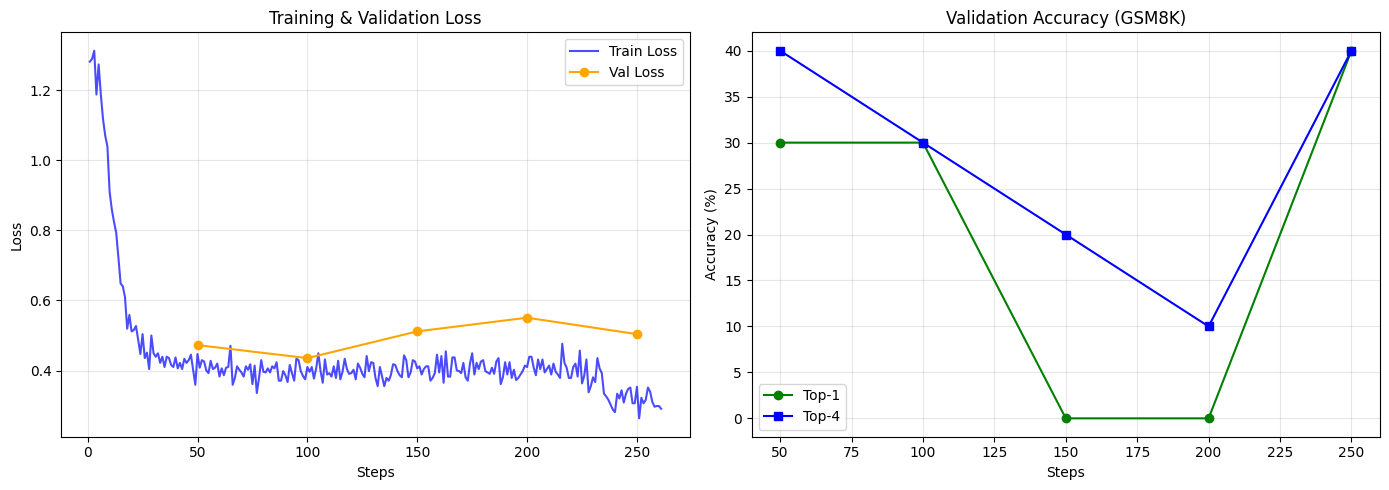

In [18]:
print(f"Final Top-1 accuracy: {last_accuracy*100:.2f}%")
print(f"Final Top-{NUM_GENERATIONS} accuracy: {last_accuracy_topk*100:.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_step'], history['train_loss'], color="blue", label="Train Loss", alpha=0.7)
ax1.plot(history['val_step'], history['val_loss'], color="orange", label="Val Loss", marker='o')
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['val_step'], [a*100 for a in history['val_top1']], color="green", marker='o', label="Top-1")
ax2.plot(history['val_step'], [a*100 for a in history['val_topk']], color="blue", marker='s', label=f"Top-{NUM_GENERATIONS}")
ax2.set_title("Validation Accuracy (GSM8K)")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

In [24]:
test_idx = 1
q_tokens, a_tokens = testing_data[test_idx]
question = tokenizer.decode(q_tokens, skip_special_tokens=True)
ground_truth = tokenizer.decode(a_tokens, skip_special_tokens=True)
gt_answer = extract_answer(ground_truth)
gt_num = normalize_answer(gt_answer)

print(f"Question: {question}\n")
print(f"Ground Truth Answer: {gt_answer}\n")

res = generate_with_kv_cache(
    tt_model, tokenizer, list(q_tokens), logits_mask_tensor,
    max_gen_tokens, max_sequence_length, batch_size=NUM_GENERATIONS
)

for i, r in enumerate(res):
    pred_answer = extract_answer(r)
    pred_num = normalize_answer(pred_answer)
    is_correct = answers_match(gt_num, pred_num)
    print(f"[{i}] Predicted: {pred_answer} | {'✓ Correct' if is_correct else '✗ Wrong'}")
    print(f"    Response: {r}")

Question: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?

Ground Truth Answer: 3



  0%|          | 0/557 [00:00<?, ?it/s]

[0] Predicted: 3 | ✓ Correct
    Response:  2/2=<<2/2=1>>1 white
2+1=<<2+1=3>>3 bolts
#### 3
[1] Predicted: 22 | ✗ Wrong
    Response:  Half the number of blue bolts is 2/2=<<2/2=1>>1
So it takes 2+1=<<2+11=22222  blue >>222+2+22>>2+2>>2>>21/2+2212>>2>>222>>212+22 it212522  blue total=  takes 22 number   it  the222=22+212121It2 of222 2 >>22 total it takes 2222 <<2 of22121<<21222<<2<<1<< 22+2222=22 the number it22222>>22>> 2== the number  the it number 21122= it total the half:=>>1 it it the white/111>>2/1/21=<<1>> the half it it it22+11>>= half
  it it1522 the  total half it takes   1 11>>22=1>>11>>11>>11>>1  it takes 2 112>>2 total the1 total112 number  the  21+1=
1>> it of1>>2./ +21+2
2 the 1 total 22122  the<< it it it it1/=1>> the it
  1>> it12 the the 1<< 2=2 212= 1=1/ it it it1522 it the  1 12211 the the2 total of it takes the21 22  22/1/1211/22>>111 the22/2/2112>>  half the1222 the the the2 2 half221 the half half it>>21+2=2++2=2+1>>1f 21=1/2++2
  the222  the number of of of
 1 